In [2]:
import sys
sys.path.append("../")

import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import chi2

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step
from datasets import load_data

EPS = 1e-7

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('viridis_r')

import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
import matplotlib

logging.getLogger('matplotlib').setLevel(logging.ERROR)

/tmp/ipykernel_1757110/764414799.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis_r')
/tmp/ipykernel_1757110/764414799.py:10: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


## Dirs

In [4]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"
logging_dir = "/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
run_name = "gallant-cherry-87"

In [5]:
import sys
sys.path.append("../")

from datasets import get_nbody_data
x, _, conditioning, norm_dict = get_nbody_data(n_features=3, n_particles=5000, split="test")

## Load cluster run

In [6]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [7]:
# Load the dataset
train_ds, norm_dict = load_data(
        config.data.dataset,
        config.data.n_features,
        config.data.n_particles,
        32,
        config.seed,
        shuffle=True,
        split="test",
    )

batches = create_input_iter(train_ds)

In [8]:
x, conditioning, mask = next(batches)
x = x.reshape(-1, config.data.n_particles, config.data.n_features)
conditioning = conditioning.reshape(-1, 2)
mask = mask.reshape(-1, config.data.n_particles)

In [9]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config.data.apply_pbcs = False
box_size = config.data.box_size #if config.data.apply_pbcs else None
unit_cell = tuple(map(tuple, config.data.unit_cell)) if config.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": box_size,
        "unit_cell": unit_cell,
    }
)

In [10]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
        d_feature=config.data.n_features,
        timesteps=config.vdm.timesteps,
        noise_schedule=config.vdm.noise_schedule,
        noise_scale=config.vdm.noise_scale,
        d_t_embedding=config.vdm.d_t_embedding,
        gamma_min=config.vdm.gamma_min,
        gamma_max=config.vdm.gamma_max,
        score=config.score.score,
        score_dict=score_dict,
        embed_context=config.vdm.embed_context,
        d_context_embedding=config.vdm.d_context_embedding,
        n_classes=config.vdm.n_classes,
        use_encdec=config.vdm.use_encdec,
        encoder_dict=encoder_dict,
        decoder_dict=decoder_dict,
        norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
if hasattr(config.optim, "grad_clip"):
    if config.optim.grad_clip is not None:
        tx = optax.chain(
            optax.clip(config.optim.grad_clip),
            tx,
        )

state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 637,373


In [11]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=295000)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Generate and evaluate simulations

In [ ]:
n_samples = 2
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=cond_gen, mask=mask_gen, steps=500)
x_samples = x_samples.mean()

In [ ]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

## Likelihood eval

In [13]:
def elbo(vdm, params, rng, x, conditioning, mask, steps=20, T=1., unroll_loop=False):
    rng, spl = jax.random.split(rng)
    cond = vdm.apply(params, conditioning, method=vdm.embed)
    f = vdm.apply(params, x, conditioning, method=vdm.encode)
    loss_recon = vdm.apply(params, x, f, conditioning, rngs={"sample": rng}, method=vdm.recon_loss)
    loss_klz = vdm.apply(params, f, method=vdm.latent_loss)
    
    if not unroll_loop:

        def body_fun(i, val):
            loss, rng = val
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]) * T, f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            return (loss + (new_loss * mask[..., None]).sum((-1, -2)) / steps, rng)

        loss_diff, rng = jax.lax.fori_loop(0, steps, body_fun, (np.zeros(x.shape[0]), rng))

    else:
        
        loss_diff, rng = (np.zeros(x.shape[0]), rng)

        for i in range(steps):
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]) * T, f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            loss_diff =  loss_diff + (new_loss * mask[..., None]).sum((-1, -2)) / steps

    return ((loss_recon * mask[..., None]).sum((-1, -2)) + (loss_klz * mask[..., None]).sum((-1, -2)) + loss_diff)

In [14]:
from functools import partial

@partial(jax.jit, static_argnums=(3,4,5))
def likelihood(theta_test, x_test, rng, n_samples=1, steps=50, T=1.):
    x_test = np.repeat(np.array([x_test]), n_samples, 0)
    theta_test = np.repeat(np.array([theta_test]), n_samples, 0)
    return -elbo(vdm, restored_state.params, rng, x_test, theta_test, np.ones_like(x_test[..., 0]), steps=steps, T=T).mean()

In [15]:
idx = 16

x_test = x[idx]

Omega_m = conditioning[idx][0]
sigma_8 = conditioning[idx][1]

theta_test = np.array([Omega_m, sigma_8])
likelihood(theta_test, x_test, rng, )

Array(-19560.414, dtype=float32)

In [16]:
sigma_8_ary = np.linspace(0.6, 1.0, 30)
n_test = 64

log_like_sigma8_profs = []
rng = jax.random.PRNGKey(42)

for _ in tqdm(range(n_test)):

    rng, _ = jax.random.split(rng)

    log_like = []

    for sigma_8 in sigma_8_ary:
        theta_test = np.array([conditioning[idx][0], sigma_8])
        log_like.append(likelihood(theta_test, x_test, rng, ))

    log_like_sigma8_profs.append(log_like)

100%|████████████████████████████████████████████| 64/64 [25:24<00:00, 23.82s/it]


In [17]:
np.array(log_like_sigma8_profs).max(axis=1).std()  # RMS variation

Array(124.288315, dtype=float32)

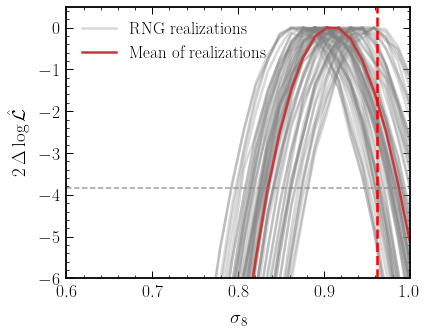

In [19]:
for idx_i in range(n_test):
    plt.plot(sigma_8_ary, 2 * (np.array(log_like_sigma8_profs[idx_i]) - np.max(np.array(log_like_sigma8_profs[idx_i]))), color='grey', alpha=0.3, label="RNG realizations" if idx_i == 0 else None)

plt.plot(sigma_8_ary, 2 * (np.mean(np.array(log_like_sigma8_profs), axis=0)  - np.max(np.mean(np.array(log_like_sigma8_profs), axis=0))), color=cols_default[0], alpha=1., label="Mean of realizations")

plt.axvline(conditioning[idx][1], ls='--', color='red')
plt.xlim(0.6, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), lw=1.5, ls = '--', color='grey', alpha=0.75)
# plt.text(0.7, -chi2.isf(1 - .95, 1) + 0.2, r"$1\sigma$", fontsize=18, color='grey', alpha=0.75)
plt.ylabel(r"$2\,\Delta \log \hat \mathcal L$")
plt.xlabel(r"$\sigma_8$")

plt.legend()

In [18]:
omega_m_ary = np.linspace(0.1, 0.5, 30)

log_like_omegam_profs = []
rng = jax.random.PRNGKey(42)

for _ in tqdm(range(n_test)):

    rng, _ = jax.random.split(rng)

    log_like = []

    for omegam in omega_m_ary:
        theta_test = np.array([omegam, conditioning[idx][1]])
        log_like.append(likelihood(theta_test, x_test, rng, ))

    log_like_omegam_profs.append(log_like)

100%|████████████████████████████████████████████| 64/64 [25:25<00:00, 23.84s/it]


In [20]:
np.array(log_like_omegam_profs).max(axis=1).std()  # RMS variation

Array(124.55956, dtype=float32)

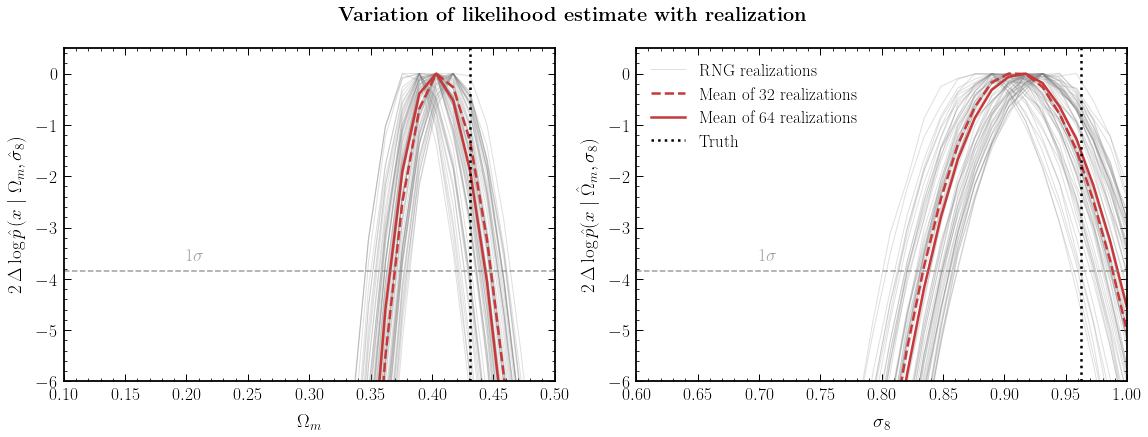

In [29]:
from scipy.stats import chi2

n_small = 32

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for idx_i in range(n_test):
    ax[0].plot(omega_m_ary, 2 * (np.array(log_like_omegam_profs[idx_i]) - np.max(np.array(log_like_omegam_profs[idx_i]))), color='grey', lw=1, alpha=0.25, label="RNG realizations" if idx_i == 0 else None)

ax[0].plot(omega_m_ary, 2 * (np.mean(np.array(log_like_omegam_profs)[:n_small], axis=0)  - np.max(np.mean(np.array(log_like_omegam_profs)[:n_small], axis=0))), color=cols_default[0], ls='--', alpha=1., label=f"Mean of {n_small} realizations")
ax[0].plot(omega_m_ary, 2 * (np.mean(np.array(log_like_omegam_profs), axis=0)  - np.max(np.mean(np.array(log_like_omegam_profs), axis=0))), color=cols_default[0], alpha=1., label="Mean of 64 realizations")

ax[0].axvline(conditioning[idx][0], ls=':', color='k')
ax[0].set_xlim(0.1, 0.5)
ax[0].set_ylim(-6, 0.5)

ax[0].axhline(-chi2.isf(1 - .95, 1), lw=1.5, ls = '--', color='grey', alpha=0.75)
ax[0].text(0.2, -chi2.isf(1 - .95, 1) + 0.2, "$1\sigma$", fontsize=18, color='grey', alpha=0.75)
ax[0].set_ylabel(r"$2\,\Delta \log \hat p\left(x\mid\Omega_m, \hat \sigma_8\right)$")
ax[0].set_xlabel(r"$\Omega_m$")

for idx_i in range(n_test):
    ax[1].plot(sigma_8_ary, 2 * (np.array(log_like_sigma8_profs[idx_i]) - np.max(np.array(log_like_sigma8_profs[idx_i]))), color='grey', lw=1, alpha=0.25, label="RNG realizations" if idx_i == 0 else None)

ax[1].plot(sigma_8_ary, 2 * (np.mean(np.array(log_like_sigma8_profs)[:n_small], axis=0)  - np.max(np.mean(np.array(log_like_sigma8_profs)[:n_small], axis=0))), color=cols_default[0], alpha=1., ls='--', label=f"Mean of {n_small} realizations")
ax[1].plot(sigma_8_ary, 2 * (np.mean(np.array(log_like_sigma8_profs), axis=0)  - np.max(np.mean(np.array(log_like_sigma8_profs), axis=0))), color=cols_default[0], alpha=1., label="Mean of 64 realizations")

ax[1].axvline(conditioning[idx][1], label="Truth", ls=':', color='k')
ax[1].set_xlim(0.6, 1)
ax[1].set_ylim(-6, 0.5)

ax[1].axhline(-chi2.isf(1 - .95, 1), lw=1.5, ls = '--', color='grey', alpha=0.75)
ax[1].text(0.7, -chi2.isf(1 - .95, 1) + 0.2, "$1\sigma$", fontsize=18, color='grey', alpha=0.75)
ax[1].set_ylabel(r"$2\,\Delta \log \hat p(x\mid \hat \Omega_m,\sigma_8)$")
ax[1].set_xlabel(r"$\sigma_8$")

ax[1].legend()

fig.suptitle(r"\textbf{Variation of likelihood estimate with realization", fontsize=20, y=1.005)
plt.tight_layout()

plt.savefig("plots/ll_realiz.pdf", bbox_inches='tight')